<a href="https://colab.research.google.com/github/Egoago/Onlab/blob/main/%C3%96nlab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D regression

##Preparing the data

###Defining the control points

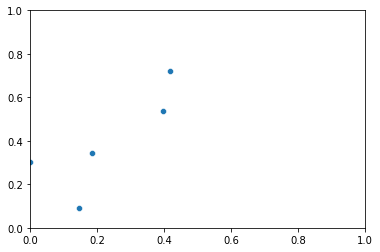

In [46]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(1)
pointNum = 5
points = np.random.random((pointNum,2))
sns.scatterplot(x=points[:,0], y=points[:,1]).set(xlim=(0,1),ylim=(0,1));

###Defining training data generator

In [47]:
from tensorflow.keras.utils import Sequence
from math import ceil

class DataGenerator(Sequence):
  seed = 0
  def __init__(self, dataCount, batch_size, controlPoints):
    self.controlPoints = controlPoints
    self.dataCount = dataCount
    self.batch_size = batch_size
    self.seed = DataGenerator.seed
    DataGenerator.seed += 1
    self.randGen = np.random.default_rng(seed=self.seed)

  def __len__(self):
    return ceil(self.dataCount / self.batch_size)

  def dist(self, p):
    return np.linalg.norm(self.controlPoints-p, axis = 1).min()

  def __getitem__(self, idx):
    P = []
    d = []
    for i in range(self.batch_size):
      p = self.randGen.random(2)
      P.append(p)
      d.append(self.dist(p))
    return np.array(P), np.array(d)

  def on_epoch_end(self):
    self.randGen = np.random.default_rng(seed=self.seed)
  
  def getAll(self):
    self.on_epoch_end()
    P = []
    d = []
    for i in range(self.batch_size * self.__len__()):
      p = self.randGen.random(2)
      P.append(p)
      d.append(self.dist(p))
    self.on_epoch_end()
    return np.array(P), np.array(d)

###Creating generators

In [48]:
pointNum = 30000
validSplit = 0.1
testSplit  = 0.1
trainPointNum = int(pointNum*(1-validSplit-testSplit))
validPointNum = int(pointNum*validSplit)
testPointNum = int(pointNum*testSplit)

trainGen = DataGenerator(trainPointNum, 32, points)
validGen = DataGenerator(validPointNum, 32, points)
testGen = DataGenerator(testPointNum, 32, points)

##Creating model

In [49]:
from tensorflow.keras.models import Sequential
'''
  This part will be necessary when we will override the forward path
  instead of running it again during the process of calculationg
  the gradient of the model with respect of the input.
'''
class CustomModel(Sequential):
  def __init__(self, *args, **kwargs):
    self.stepCounter = 0
    Sequential.__init__(self, *args, **kwargs)

  def train_step(self, data):
    print(f'train step: {self.stepCounter}')
    self.stepCounter += 1
    return Sequential.train_step(self, data)

In [50]:
from tensorflow.keras.layers import Dense

model = CustomModel([
    Dense(64, activation='relu', kernel_initializer='he_normal', input_shape = (2,)),
    Dense(1, activation='linear')
])
model.summary()

Model: "custom_model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


###Defining the loss function

In [71]:
from tensorflow.math import reduce_mean, square
shapes = []
def lossFunction(yTrue, yPred):
  shapes.append(yPred.shape)
  return mse(yTrue, yPred)

def mse(y_true, y_pred):
    squared_difference = square(y_true - y_pred)
    return reduce_mean(squared_difference, axis=1)

In [72]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer = 'adam',
              loss = lossFunction)
es = EarlyStopping(min_delta = 1e-6,
                        patience = 5,
                        verbose = 2,
                        restore_best_weights = True)

##Train

In [73]:
epochs = 5
history = model.fit(trainGen,
                    validation_data = validGen,
                    verbose = 1,
                    callbacks = [es],
                    epochs = epochs)

Epoch 1/5
train step: 7
train step: 8
750/750 [==============================] - 2s 3ms/step - loss: 7.2833e-04 - val_loss: 6.7730e-04
Epoch 2/5
750/750 [==============================] - 2s 3ms/step - loss: 7.1712e-04 - val_loss: 6.7803e-04
Epoch 3/5
750/750 [==============================] - 2s 2ms/step - loss: 7.1173e-04 - val_loss: 6.7030e-04
Epoch 4/5
750/750 [==============================] - 2s 2ms/step - loss: 7.0539e-04 - val_loss: 6.6464e-04
Epoch 5/5
750/750 [==============================] - 2s 2ms/step - loss: 6.9829e-04 - val_loss: 6.6012e-04


##Evaluate

loss on test data: 0.000670374371111393


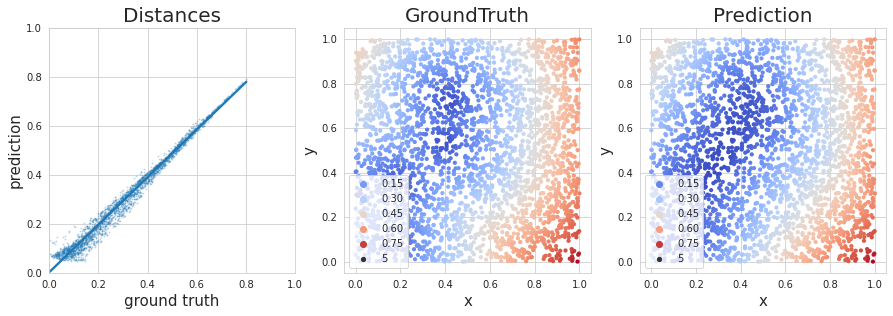

In [74]:
testX, testY = testGen.getAll()
print(f'loss on test data: {model.evaluate(testX, testY, verbose=0)}')
prediction = model.predict(testX)
plots = []
sns.set_style("whitegrid")
fig, axs = plt.subplots(ncols = 3,
                        figsize=(15,4.5))
plots.append(sns.regplot(x = testY, y = prediction, ax=axs[0], scatter_kws={'s':1, 'alpha':0.2}))
plots.append(sns.scatterplot(x=testX[:,0], y=testX[:,1], hue = testY, size = 5, linewidth = 0, palette='coolwarm', ax=axs[1]))
plots.append(sns.scatterplot(x=testX[:,0], y=testX[:,1], hue = prediction.reshape(-1), size = 5, linewidth = 0, palette='coolwarm', ax=axs[2]))
plots[0].set_title('Distances', fontsize = 20)
plots[0].set_ylabel('prediction', fontsize = 15)
plots[0].set(ylim=(0,1),xlim=(0,1))
plots[0].set_xlabel('ground truth', fontsize = 15)
plots[1].set_xlabel('x', fontsize = 15)
plots[1].set_ylabel('y', fontsize = 15)
plots[1].set_title('GroundTruth', fontsize = 20)
plots[2].set_xlabel('x', fontsize = 15)
plots[2].set_ylabel('y', fontsize = 15)
plots[2].set_title('Prediction', fontsize = 20);

In [75]:
shapes

[TensorShape([None, 1]),
 TensorShape([None, 1]),
 TensorShape([None, 1]),
 TensorShape([32, 1])]

##Plot Model

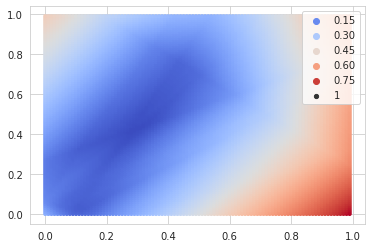

In [62]:
resolution = 100
grid = np.empty((resolution*resolution,2))
for y in range(resolution):
  for x in range(resolution):
    grid[y*resolution+x] = [x/resolution, y/resolution]
prediction = model.predict(grid)
sns.scatterplot(x=grid[:,0],
                y=grid[:,1],
                hue = prediction.reshape(-1),
                size = 1,
                linewidth = 0,
                palette='coolwarm');
